In [51]:
import os, sys, email,re
import numpy as np 
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
import wordcloud

# Network analysis
import networkx as nx

# NLP
from nltk.tokenize.regexp import RegexpTokenizer

from subprocess import check_output

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation

import gensim
from gensim import corpora
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.stem.porter import PorterStemmer

In [52]:
# Read the data into a DataFrame
emails_df = pd.read_csv('/kaggle/input/emails.csv')
print(emails_df.shape)
emails_df.head()

(517401, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [53]:
## Helper functions
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [54]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]
# Parse content from emails
emails_df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages

emails_df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


In [55]:
# Set index and drop columns with two few values
emails_df = emails_df.set_index('Message-ID')\
    .drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)
# Parse datetime
emails_df['Date'] = pd.to_datetime(emails_df['Date'], infer_datetime_format=True)

In [56]:
def clean(text):
    stop = set(stopwords.words('english'))
    stop.update(("to","cc","subject","http","from","sent","aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa"))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    porter= PorterStemmer()
    
    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    #stem = " ".join(porter.stem(token) for token in normalized.split())
    
    return normalized

In [57]:
re.sub(r'[^a-zA-Z]', ' ', "etienne ,//hgjhk jgjhg")

'etienne    hgjhk jgjhg'

In [58]:
analysis_df=emails_df[['From', 'To', 'Date','content']].dropna().copy()
analysis_df = analysis_df.loc[analysis_df['To'].map(len) == 1]
sub_df=analysis_df.sample(1000)

In [59]:
#sub_df["content"]=sub_df["content"].map(clean)
text_clean=[]
for text in sub_df['content']:
    text_clean.append(clean(text).split())

In [60]:
dictionary = corpora.Dictionary(text_clean)
text_term_matrix = [dictionary.doc2bow(text) for text in text_clean]

In [61]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(text_term_matrix, num_topics=4, id2word = dictionary, passes=30)

In [62]:
eng_stopwords = set(stopwords.words('english'))
def clean_text(text):
    #text = BeautifulSoup(text, 'html.parser').get_text()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.lower().split()
    words = [w for w in words if w not in eng_stopwords]
    return ' '.join(words)

analysis_df["clean_content"]=analysis_df.content.apply(clean_text)

In [63]:
wordvector = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.4, min_df=5)
short_analysis=analysis_df.sample(5000)
wordvector_fit = wordvector.fit_transform(short_analysis.clean_content)
feature = wordvector.get_feature_names()

In [64]:
N = 4
clf = KMeans(n_clusters=N, 
            max_iter=50, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(wordvector_fit)

In [65]:
wordvector_fit_2d = wordvector_fit.todense()
pca = PCA(n_components=2).fit(wordvector_fit_2d)
datapoint = pca.transform(wordvector_fit_2d)

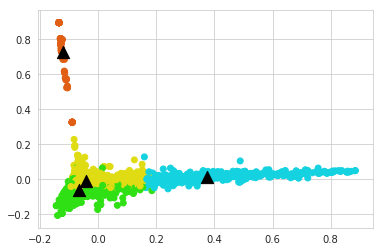

<Figure size 720x720 with 0 Axes>

In [68]:
label = ["#e05f14", "#e0dc14", "#2fe014", "#14d2e0"]
color = [label[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()